Reference: https://github.com/manish-vi/social_network_graph_link_prediction

### Read files

In [105]:
import pandas as pd

train_df = pd.read_csv("train.csv")

### Create graph

In [106]:
import networkx as nx
import math


G = nx.from_pandas_edgelist(
    train_df[train_df["label"] == 1], "node1", target="node2", create_using=nx.DiGraph()
)

print(G)


def count_successors(G, node):
    if G.has_node(node):
        return len(list(G.successors(node)))
    return 0


def count_predecessors(G, node):
    if G.has_node(node):
        return len(list(G.predecessors(node)))
    return 0


train_df["successor_count"] = train_df["node1"].apply(lambda x: count_successors(G, x))
train_df["predecessor_count"] = train_df["node2"].apply(
    lambda x: count_predecessors(G, x)
)


def count_common_neighbors(G, node1, node2):
    if G.has_node(node1) and G.has_node(node2):
        succs1 = set(G.successors(node1))
        succs2 = set(G.successors(node2))
        return len(succs1 & succs2)
    return 0


train_df["common_neighbors"] = train_df.apply(
    lambda row: count_common_neighbors(G, row["node1"], row["node2"]), axis=1
)


def compute_jaccard_coefficient(G, node1, node2):
    if G.has_node(node1) and G.has_node(node2):
        succs1 = set(G.successors(node1))
        succs2 = set(G.successors(node2))
        union_size = len(succs1 | succs2)
        if union_size == 0:
            return 0
        return len(succs1 & succs2) / union_size
    return 0


train_df["jaccard_coefficient"] = train_df.apply(
    lambda row: compute_jaccard_coefficient(G, row["node1"], row["node2"]), axis=1
)


def compute_adamic_adar_index(G, node1, node2):
    if G.has_node(node1) and G.has_node(node2):
        succs1 = set(G.successors(node1))
        succs2 = set(G.successors(node2))
        common_succs = succs1 & succs2
        return sum(1 / math.log(G.degree(v)) for v in common_succs)
    return 0


train_df["adamic_adar_index"] = train_df.apply(
    lambda row: compute_adamic_adar_index(G, row["node1"], row["node2"]), axis=1
)

# def compute_katz_centrality(G, node):
#     katz_centrality = nx.katz_centrality(G, alpha=0.005, beta=1.0)
#     if node in katz_centrality:
#         return katz_centrality[node]
#     return 0

#
# train_df["katz_centrality"] = train_df["node1"].apply(lambda x: compute_katz_centrality(G, x))


def compute_preferential_attachment(G, node1, node2):
    if G.has_node(node1) and G.has_node(node2):
        return G.degree(node1) * G.degree(node2)
    return 0


train_df["preferential_attachment"] = train_df.apply(
    lambda row: compute_preferential_attachment(G, row["node1"], row["node2"]), axis=1
)


def compute_clustering_coefficient(G, node):
    clustering_coefficient = nx.clustering(G)
    if node in clustering_coefficient:
        return clustering_coefficient[node]
    return 0


train_df["clustering_coefficient"] = train_df["node1"].apply(
    lambda x: compute_clustering_coefficient(G, x)
)

train_df


DiGraph with 10625 nodes and 12765 edges


,node1,node2,label,successor_count,predecessor_count,common_neighbors,jaccard_coefficient,adamic_adar_index,preferential_attachment,clustering_coefficient
0,29237,16563,1,1,1,0,0.0,0.0,1,0.000000
1,32869,24548,0,0,0,0,0.0,0.0,0,0.000000
2,48837,17831,1,2,1,0,0.0,0.0,2,0.000000
3,31387,44509,0,0,0,0,0.0,0.0,0,0.000000
4,15102,10271,1,2,1,0,0.0,0.0,2,0.000000
...,...,...,...,...,...,...,...,...,...,...
31995,51510,44952,1,1,1,0,0.0,0.0,1,0.000000
31996,30089,48199,0,0,0,0,0.0,0.0,0,0.000000
31997,1418,13815,0,0,0,0,0.0,0.0,0,0.000000
31998,5451,24600,1,9,9,0,0.0,0.0,150,0.028571


In [107]:
# train_df["jaccard_coefficient"].value_counts()

### GridSearchCV

In [108]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop(columns=["label"]), train_df["label"], test_size=0.3, random_state=0
)

clf = XGBClassifier(n_jobs=-1)

parameters = {
    "max_depth": [i for i in range(3, 100, 10)],
    "n_estimators": [i for i in range(10, 180, 20)],
}

# Grid Search, for best hyperparameter
model = GridSearchCV(
    clf,
    parameters,
    cv=5,
    verbose=10,
    scoring="f1",
    return_train_score=True,
    n_jobs=-1,
)

model.fit(X_train, y_train)
bestParameter = model.best_estimator_
print(f"\nBest Hyperparameter: {str(bestParameter)}\n")

params = bestParameter.get_params()
for key in params:
    if params[key] is not None:
        print(key, ":", params[key])

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Hyperparameter: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

objective : binary:logistic
enable_categorical : False
max_depth : 13
missing : nan
n_estimators : 10
n_jobs : -1


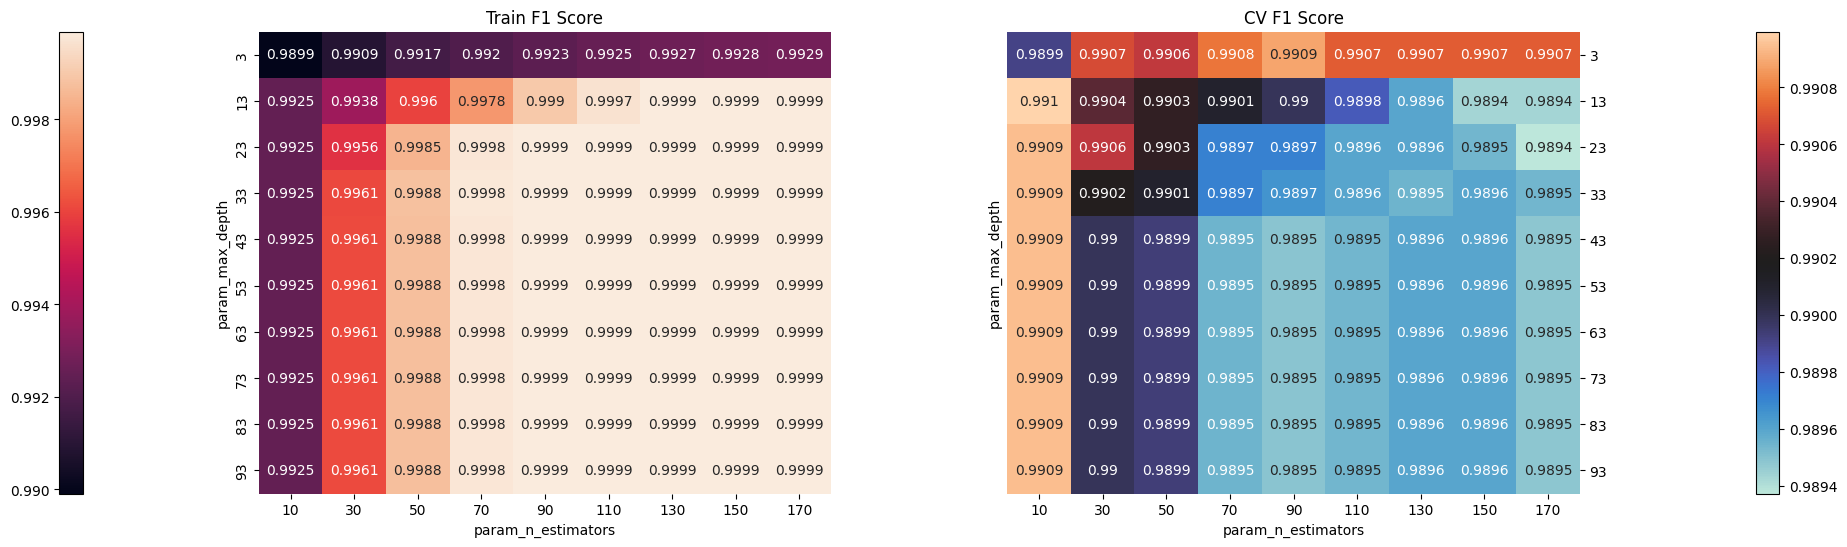

In [109]:
import matplotlib.pylab as plt
import seaborn as sns

# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(["param_max_depth", "param_n_estimators"]).max()
max_scores = max_scores.unstack()[["mean_test_score", "mean_train_score"]]

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(25, 6))
fig.subplots_adjust(wspace=0.2)

# mean_train_score
sns.heatmap(
    max_scores.mean_train_score, annot=True, fmt=".4g", cmap="rocket", ax=ax, cbar=False
)
fig.colorbar(ax.collections[0], ax=ax, location="left", use_gridspec=False, pad=0.2)

# mean_test_score
sns.heatmap(
    max_scores.mean_test_score,
    annot=True,
    fmt=".4g",
    cmap="icefire",
    ax=ax2,
    cbar=False,
)
fig.colorbar(ax2.collections[0], ax=ax2, location="right", use_gridspec=False, pad=0.2)

ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text("Train F1 Score")
ax2.title.set_text("CV F1 Score")
plt.show()

### XGBoost

In [110]:
from sklearn.metrics import accuracy_score, f1_score

print(f'max_depth = {bestParameter.max_depth}, n_estimators = {bestParameter.n_estimators}\n')
# 建立 XGBClassifier 模型
clf = XGBClassifier(
    max_depth=bestParameter.max_depth,
    n_estimators=bestParameter.n_estimators,
    n_jobs=-1,
)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)


print("Train f1 score: ", f1_score(y_train, y_train_pred))
print("Test f1 score: ", f1_score(y_test, y_test_pred))

print("Test accuracy score: ", accuracy_score(y_test, y_test_pred))


max_depth = 13, n_estimators = 10

Train f1 score:  0.9923825410063942
Test f1 score:  0.9900581020012912
Test accuracy score:  0.9919791666666666


### Confussion matrix

Train confusion_matrix


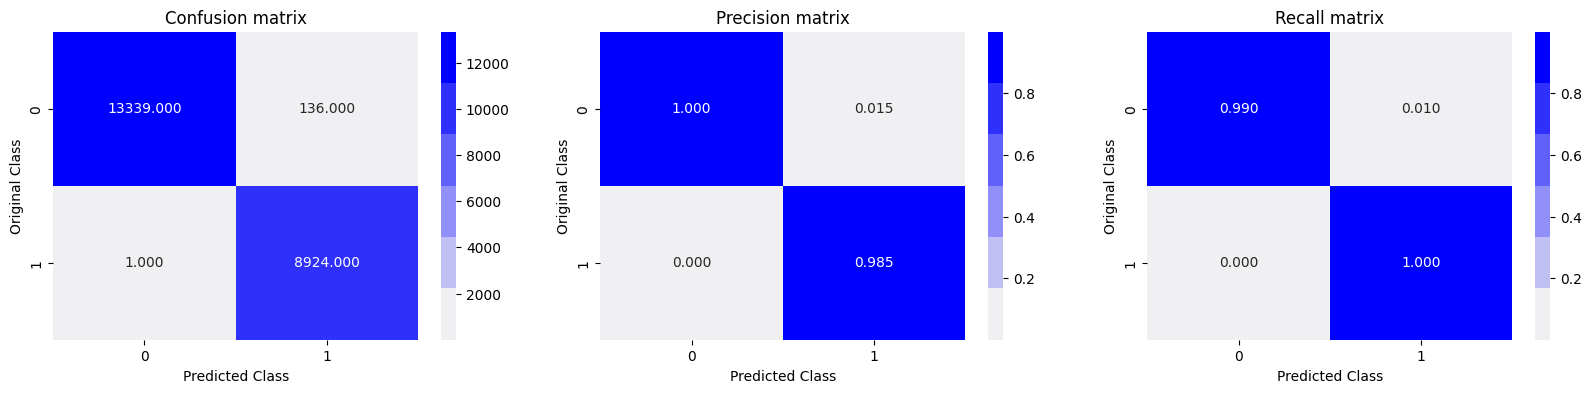

Test confusion_matrix


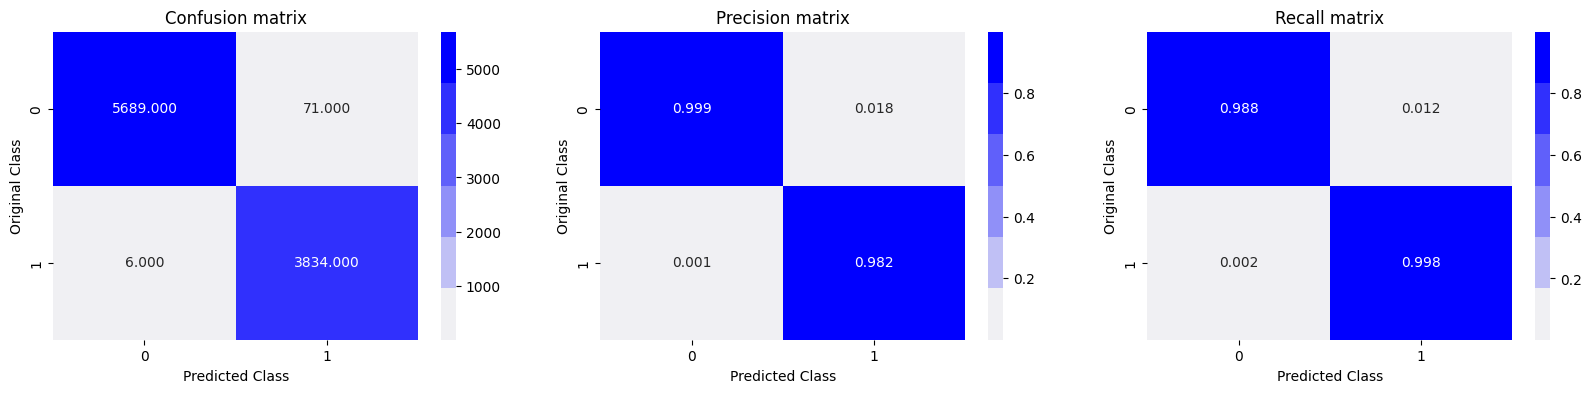

In [111]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A = ((C.T) / (C.sum(axis=1))).T

    B = C / C.sum(axis=0)
    plt.figure(figsize=(20, 4))

    labels = [0, 1]
    # representing A in heatmap format
    cmap = sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(
        C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(
        B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(
        A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Recall matrix")

    plt.show()


print("Train confusion_matrix")
plot_confusion_matrix(y_train, y_train_pred)
print("Test confusion_matrix")
plot_confusion_matrix(y_test, y_test_pred)


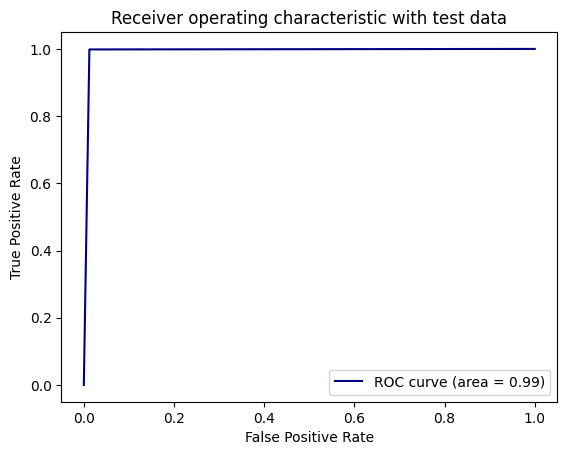

In [112]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, ths = roc_curve(y_test, y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="navy", label="ROC curve (area = %0.2f)" % auc_sc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic with test data")
plt.legend()
plt.show()

### Feature importance

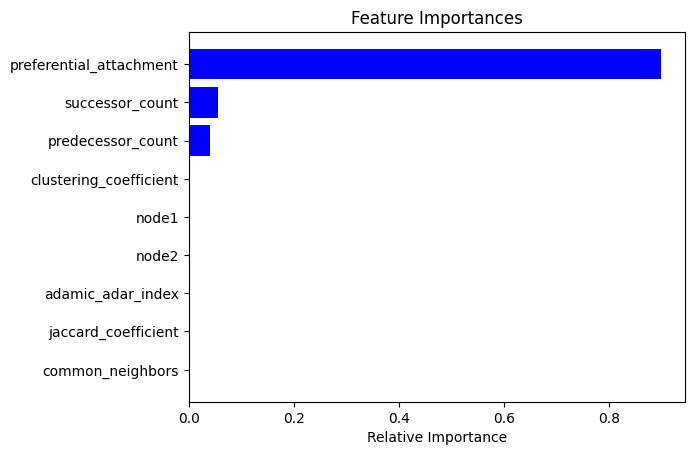

In [113]:
import numpy as np

features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-15:]
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


### HW1

In [114]:
test_df = pd.read_csv("test.csv")
test_df.drop(columns=["idx"], inplace=True)
test_df

,node1,node2
0,5416,45023
1,6681,40749
2,44162,40953
3,51387,51233
4,6498,24093
...,...,...
7995,15213,5972
7996,30870,8448
7997,5409,49118
7998,14298,45426


In [115]:
# Apply the metrics to your dataframe
test_df["successor_count"] = test_df["node1"].apply(lambda x: count_successors(G, x))
test_df["predecessor_count"] = test_df["node2"].apply(
    lambda x: count_predecessors(G, x)
)

test_df["common_neighbors"] = test_df.apply(
    lambda row: count_common_neighbors(G, row["node1"], row["node2"]), axis=1
)

test_df["jaccard_coefficient"] = test_df.apply(
    lambda row: compute_jaccard_coefficient(G, row["node1"], row["node2"]), axis=1
)

test_df["adamic_adar_index"] = test_df.apply(
    lambda row: compute_adamic_adar_index(G, row["node1"], row["node2"]), axis=1
)

test_df["preferential_attachment"] = test_df.apply(
    lambda row: compute_preferential_attachment(G, row["node1"], row["node2"]), axis=1
)

test_df["clustering_coefficient"] = test_df["node1"].apply(
    lambda x: compute_clustering_coefficient(G, x)
)

test_df


,node1,node2,successor_count,predecessor_count,common_neighbors,jaccard_coefficient,adamic_adar_index,preferential_attachment,clustering_coefficient
0,5416,45023,18,8,0,0.0,0.0,171,0.023392
1,6681,40749,0,0,0,0.0,0.0,0,0.000000
2,44162,40953,0,1,0,0.0,0.0,1,0.000000
3,51387,51233,4,13,0,0.0,0.0,112,0.035714
4,6498,24093,2,1,0,0.0,0.0,2,0.000000
...,...,...,...,...,...,...,...,...,...
7995,15213,5972,0,0,0,0.0,0.0,0,0.000000
7996,30870,8448,0,0,0,0.0,0.0,0,0.000000
7997,5409,49118,0,0,0,0.0,0.0,0,0.000000
7998,14298,45426,0,0,0,0.0,0.0,0,0.000000


In [116]:
import os

predictions = clf.predict(test_df)

file_path = "submission.csv"

# 檢查文件是否存在
if os.path.exists(file_path):
    os.remove(file_path)

# 創建包含 idx 和 predictions 的 DataFrame
df = pd.DataFrame({"idx": range(len(predictions)), "ans": predictions})

# 寫入 CSV 文件
df.to_csv("submission.csv", index=False)
